# Liver cirrhosis prediction using XGboost and Stratified K-fold⚕

By Vinay Ale

# Imports 

In [161]:
pip install shap



[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: C:\Users\vinay\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


In [162]:
# %load_ext google.colab.data_table
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Lets Load the data and have a quick look.

In [163]:
#@title Default title text
df = pd.read_csv('cirrhosis.csv', index_col='ID')
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 1 to 418
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage     

This data set has about 19 features. These features are related to the patient’s details like age, sex, etc. and patient’s blood tests like prothrombin, triglycerides, platelets levels, etc. All these factors help in understanding a patient’s chances of liver cirrhosis.

we have some NA values in our data, lets look at some statistical summary of numerical columns in out dataset.

In [165]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
N_Days,418.0,1917.782297,1104.672992,41.00,1092.7500,1730.00,2613.50,4795.00
Age,418.0,18533.351675,3815.845055,9598.00,15644.5000,18628.00,21272.50,28650.00
Bilirubin,418.0,3.220813,4.407506,0.30,0.8000,1.40,3.40,28.00
Cholesterol,284.0,369.510563,231.944545,120.00,249.5000,309.50,400.00,1775.00
Albumin,418.0,3.497440,0.424972,1.96,3.2425,3.53,3.77,4.64
Copper,310.0,97.648387,85.613920,4.00,41.2500,73.00,123.00,588.00
Alk_Phos,312.0,1982.655769,2140.388824,289.00,871.5000,1259.00,1980.00,13862.40
SGOT,312.0,122.556346,56.699525,26.35,80.6000,114.70,151.90,457.25
Tryglicerides,282.0,124.702128,65.148639,33.00,84.2500,108.00,151.00,598.00
Platelets,407.0,257.024570,98.325585,62.00,188.5000,251.00,318.00,721.00


## We have some missing values in our data, lets see how many and in which columns.

In [166]:
df.isna().sum()

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

# Handling Missing Values
This is a problem, we could just get rid of all examples with NA values, but in this case our case of small dataset we cannot afford that. 

We will impute the missing entries with some statistical calculations.

# We have two different types of data
1. Numerical data  ( Age, Cholesterol, Platelets.. etc)
2. Categorical Data ( Drug, Sex, Spiders..etc)

We will have to use different imputation for each type

1. For the numerical type we can use mean or median. In this case we will go with median to avoid skewing in the presence of outliers
2. For Categorical type we will impute the most frequent class.

In [167]:
# For Numerical Type
df.select_dtypes(include=(['int64', 'float64'])).isna().sum()

N_Days             0
Age                0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [168]:
df.select_dtypes(include=(['int64', 'float64'])).isna().sum()
df_num_col = df.select_dtypes(include=(['int64', 'float64'])).columns
for c in df_num_col:
    df[c].fillna(df[c].median(), inplace=True)

df.select_dtypes(include=(['int64', 'float64'])).isna().sum()

N_Days           0
Age              0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

In [169]:
# For Categorical type
df.select_dtypes(include=('object')).isna().sum()

Status            0
Drug            106
Sex               0
Ascites         106
Hepatomegaly    106
Spiders         106
Edema             0
dtype: int64

In [170]:
df_cat_col = df.select_dtypes(include=('object')).columns
for c in df_cat_col:
    df[c].fillna(df[c].mode().values[0], inplace=True)
    
df.select_dtypes(include=('object')).isna().sum()

Status          0
Drug            0
Sex             0
Ascites         0
Hepatomegaly    0
Spiders         0
Edema           0
dtype: int64

Alright now our dataset contains no missing values 😌

# Exploratory Data Analysys
## Lets dive into the data and visualize it, this often revels interesting patterns.
First lets take a look at how many examples per calss do we have in our dataset.

In [171]:
df['Stage'].value_counts()

3.0    161
4.0    144
2.0     92
1.0     21
Name: Stage, dtype: int64

Text(0.5, 1.0, 'Number of Example Per Class')

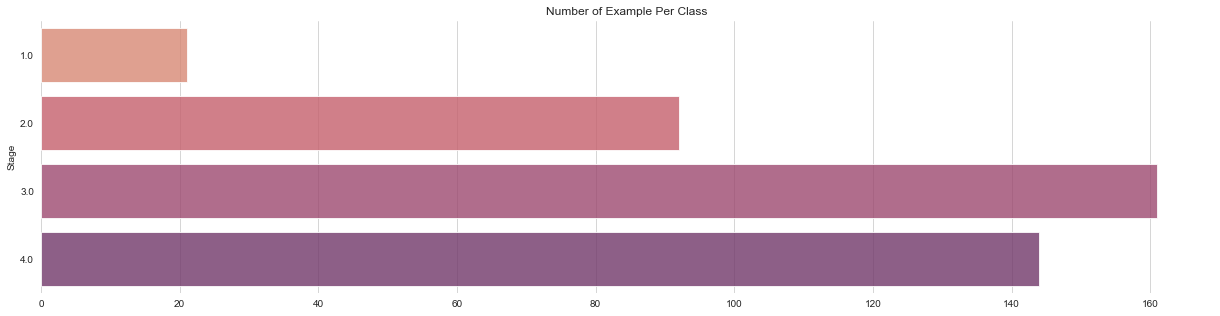

In [172]:
plt.figure(figsize=(21,5))
sns.countplot(y=df['Stage'], palette="flare", alpha=0.8, )
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Number of Example Per Class')

As we can observe we have class imbalances in our dataset i.e some classes have more examples than other. This could make it difficult for our model to train and achieve desired score. No worries, we can fix that later.

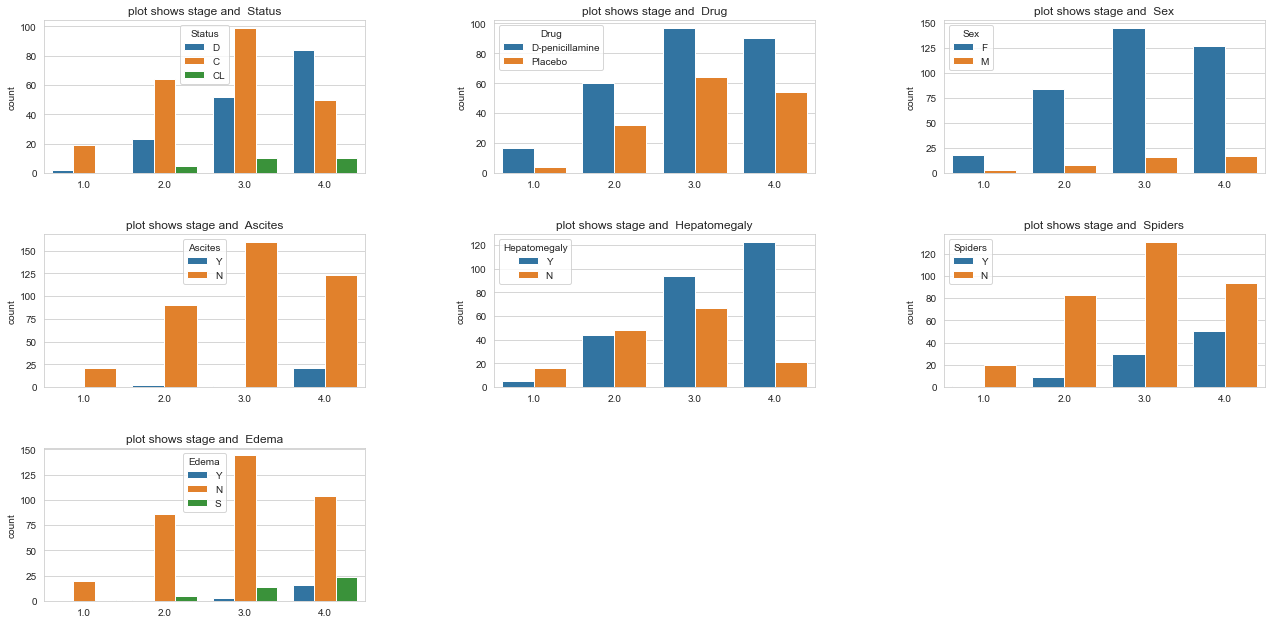

In [173]:
plt.figure(figsize=(21.2,10))
r,c,fig=5,3,1
for i in df.columns:
    if type(df[i][1])==str:
        if fig<(r*c):
            plt.subplot(r,c,fig)
            sns.countplot(x=df['Stage'],hue=df[i])
            a=f'plot shows stage and  { i}'
            plt.xlabel('')
            plt.title(a)
            plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.4, 
                    hspace=0.4)
        fig+=1

# Setting up Target and Features

### For this demonstration we will keep things simple by predicting one of the two classes  i.e (Cirrhosis and No Cirrhois). I have another project that predicts the stage of the disease, converting this problem into a multicalss classification.

In [174]:
# Converting Target categories into intigers 1 for Cirrhosis, 0 otherwise
df['Stage'] = np.where(df['Stage'] == 4,1,0)

In [175]:
df['Stage'].unique()

array([1, 0])

## Lets observe some Features with their relation with the disease

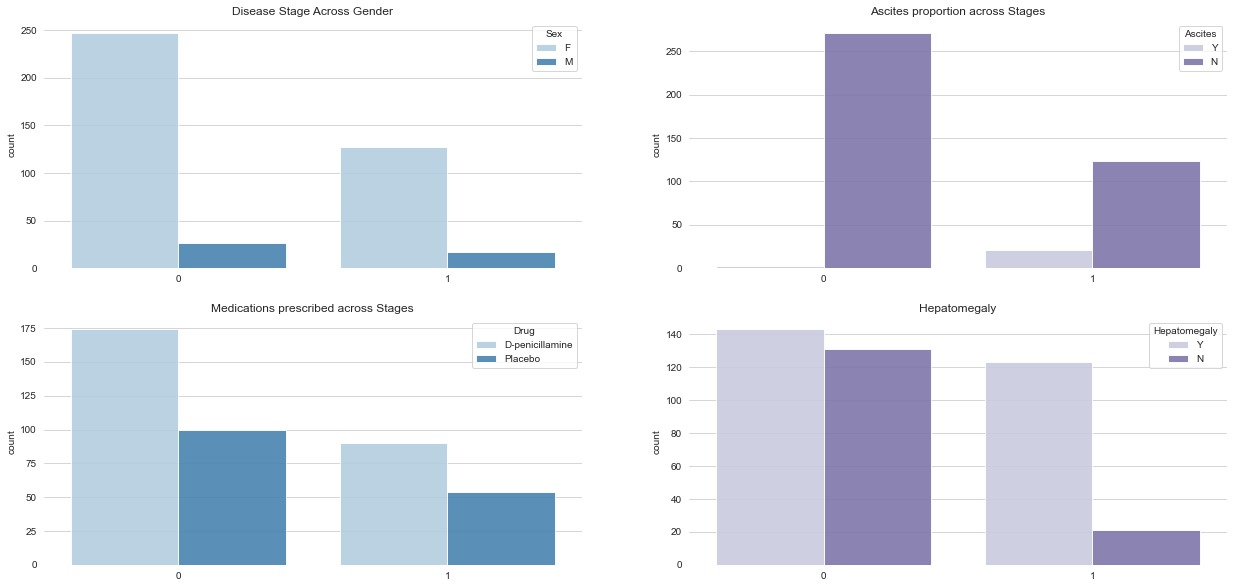

In [176]:
plt.figure(figsize=(21.2,10))

plt.subplot(2,2,1)
sns.countplot(x=df['Stage'], hue=df['Sex'], palette='Blues', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Disease Stage Across Gender')

plt.subplot(2,2,2)
sns.countplot(x=df['Stage'], hue=df['Ascites'], palette='Purples', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Ascites proportion across Stages')

plt.subplot(2,2,3)
sns.countplot(x=df['Stage'], hue=df['Drug'], palette='Blues', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Medications prescribed across Stages');

plt.subplot(2,2,4)
sns.countplot(x=df['Stage'], hue=df['Hepatomegaly'], palette='Purples', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Hepatomegaly');



There are some interesting insights if we observe closely. Take the case at Ascites, we observe that the rist of disease is higher with increase in Ascites. also presence of spiders has a positive relation with disease risk.

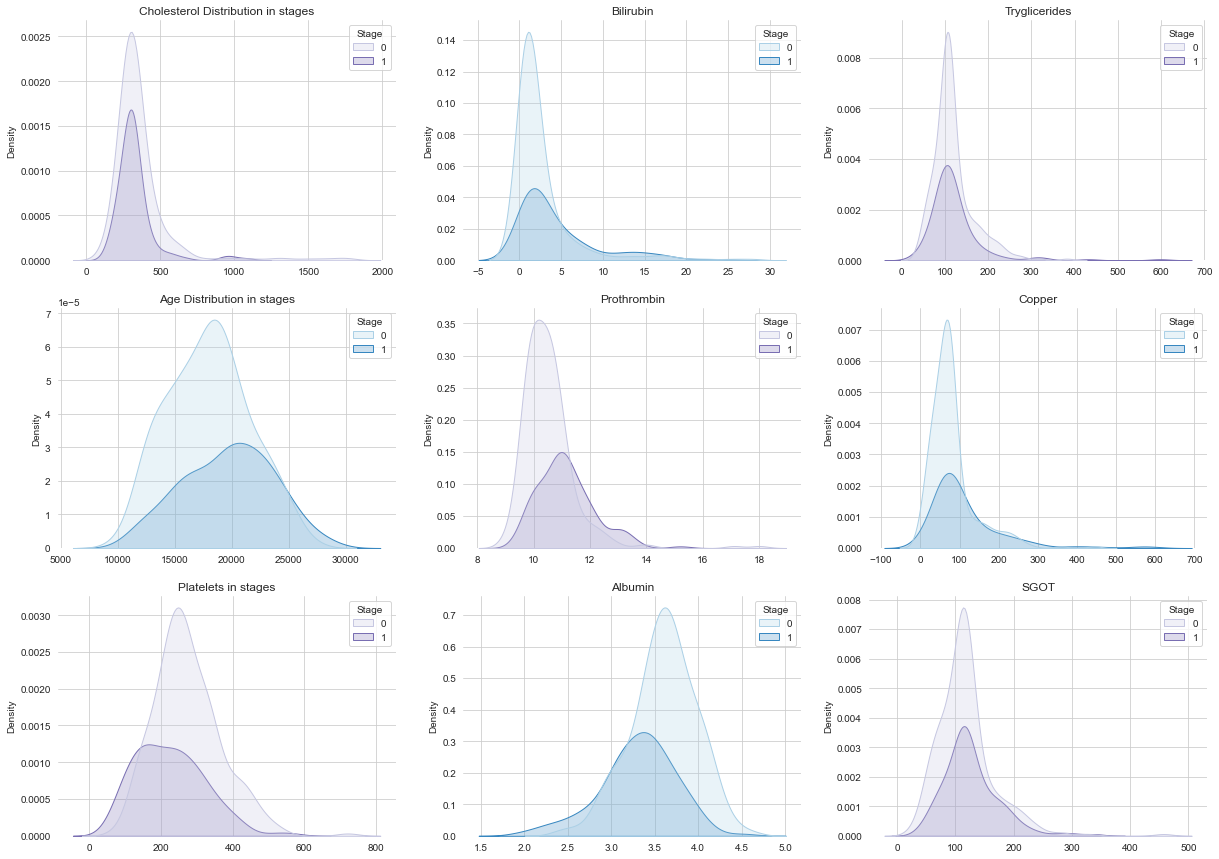

In [177]:
#@title Distribution Polts
plt.figure(figsize=(20.6,15))

plt.subplot(3,3,1)
sns.kdeplot(df['Cholesterol'], hue=df['Stage'], fill=True, palette='Purples')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Cholesterol Distribution in stages');

plt.subplot(3,3,2)
sns.kdeplot(df['Bilirubin'], hue=df['Stage'], fill=True, palette='Blues', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Bilirubin');

plt.subplot(3,3,3)
sns.kdeplot(df['Tryglicerides'], hue=df['Stage'], fill=True, palette='Purples', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Tryglicerides');

plt.subplot(3,3,4)
sns.kdeplot(df['Age'], hue=df['Stage'], fill=True, palette='Blues', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Age Distribution in stages');

plt.subplot(3,3,5)
sns.kdeplot(df['Prothrombin'], hue=df['Stage'], fill=True, palette='Purples', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Prothrombin');

plt.subplot(3,3,6)
sns.kdeplot(df['Copper'], hue=df['Stage'], fill=True, palette='Blues', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Copper');

plt.subplot(3,3,7)
sns.kdeplot(df['Platelets'], hue=df['Stage'], fill=True, palette='Purples')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Platelets in stages');

plt.subplot(3,3,8)
sns.kdeplot(df['Albumin'], hue=df['Stage'], fill=True, palette='Blues', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Albumin');

plt.subplot(3,3,9)
sns.kdeplot(df['SGOT'], hue=df['Stage'], fill=True, palette='Purples', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('SGOT');

# Preprocessing data

In [178]:
# replacing catagorical data with intigers.
df['Sex'] = df['Sex'].replace({'M':0, 'F':1})                                # Male : 0 , Female :1
df['Ascites'] = df['Ascites'].replace({'N':0, 'Y':1})                        # N : 0, Y : 1   
df['Drug'] = df['Drug'].replace({'D-penicillamine':0, 'Placebo':1})          # D-penicillamine : 0, Placebo : 1   
df['Hepatomegaly'] = df['Hepatomegaly'].replace({'N':0, 'Y':1})              # N : 0, Y : 1
df['Spiders'] = df['Spiders'].replace({'N':0, 'Y':1})                        # N : 0, Y : 1
df['Edema'] = df['Edema'].replace({'N':0, 'Y':1, 'S':-1})                    # N : 0, Y : 1, S : -1
df['Status'] = df['Status'].replace({'C':0, 'CL':1, 'D':-1})                 # 'C':0, 'CL':1, 'D':-1

## We will not be using 'Status' and 'N_days' as our features since this will cause data Leakage.

In [179]:
# Setting up Features and Target
X = df.drop(['Status', 'N_Days', 'Stage'], axis=1)
y = df.pop('Stage')

### Earlier while examining the distribution of target in the data, we found that the data is unevenly distributed, that is there are more examples of a certain class than other. 

###To tackel this imbalance we will use **Stratified k-Fold** Cross Validation.

# Model Selection. 
lets first try out a quick Logestic regression classifier and see how it performs.

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

log_model = LogisticRegression(max_iter=5000, solver='saga')
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

acc=[]
def training(train, test, fold_no):
  X_train = train
  y_train = y.iloc[train_index]
  X_test = test
  y_test = y.iloc[test_index]
  log_model.fit(X_train, y_train)
  score = log_model.score(X_test,y_test)
  acc.append(score)
  print('For Fold {} the accuracy is {}'.format(str(fold_no),score))

fold_no = 1
for train_index,test_index in skf.split(X, y):
  train = X.iloc[train_index,:]
  test = X.iloc[test_index,:]
  training(train, test, fold_no)
  fold_no += 1
print()
print('Logestic Regression Mean Accuracy = ', np.mean(acc))

For Fold 1 the accuracy is 0.6904761904761905
For Fold 2 the accuracy is 0.7857142857142857
For Fold 3 the accuracy is 0.6190476190476191
For Fold 4 the accuracy is 0.6666666666666666
For Fold 5 the accuracy is 0.8095238095238095
For Fold 6 the accuracy is 0.6666666666666666
For Fold 7 the accuracy is 0.6904761904761905
For Fold 8 the accuracy is 0.7380952380952381
For Fold 9 the accuracy is 0.7317073170731707
For Fold 10 the accuracy is 0.6341463414634146

Logestic Regression Mean Accuracy =  0.7032520325203252


In [181]:
from sklearn.metrics import classification_report
log_model_predict = log_model.predict(test)
log_model_predict_proba = log_model.predict_proba(test)

print(classification_report(y.iloc[test_index], log_model_predict))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74        27
           1       0.45      0.36      0.40        14

    accuracy                           0.63        41
   macro avg       0.58      0.57      0.57        41
weighted avg       0.62      0.63      0.62        41



## Lets try Gradient Boosted Classifier from **XGboost**.

In [182]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
model = XGBClassifier(learning_rate=0.75, max_depth=3, random_state=1, gamma=0, eval_metric='error') # tried learning rate values between range [0.01 - 10] & depth [2-8]

acc=[]
def training(train, test, fold_no):
  X_train = train
  y_train = y.iloc[train_index]
  X_test = test
  y_test = y.iloc[test_index]
  model.fit(X_train, y_train)
  score = model.score(X_test,y_test)
  acc.append(score)
  print('For Fold {} the accuracy is {}'.format(str(fold_no),score))

fold_no = 1
for train_index,test_index in skf.split(X, y):
  train = X.iloc[train_index,:]
  test = X.iloc[test_index,:]
  training(train, test, fold_no)
  fold_no += 1
print()
print('XGboost model Mean Accuracy = ', np.mean(acc))

For Fold 1 the accuracy is 0.7857142857142857
For Fold 2 the accuracy is 0.7619047619047619
For Fold 3 the accuracy is 0.6428571428571429
For Fold 4 the accuracy is 0.7380952380952381
For Fold 5 the accuracy is 0.7619047619047619
For Fold 6 the accuracy is 0.7142857142857143
For Fold 7 the accuracy is 0.7142857142857143
For Fold 8 the accuracy is 0.7619047619047619
For Fold 9 the accuracy is 0.6829268292682927
For Fold 10 the accuracy is 0.7804878048780488

XGboost model Mean Accuracy =  0.7344367015098723


In [183]:
from sklearn.metrics import classification_report
XGB_model_predict = model.predict(test)
XGB_model_predict_proba = model.predict_proba(test)

print(classification_report(y.iloc[test_index], XGB_model_predict))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84        27
           1       0.69      0.64      0.67        14

    accuracy                           0.78        41
   macro avg       0.76      0.75      0.75        41
weighted avg       0.78      0.78      0.78        41

